
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 複数の GPU の簡潔な実装

:label: `sec_multi_gpu_concise`

新しいモデルごとに並列処理を最初から実装するのは楽しいことではありません。さらに、同期ツールを最適化してパフォーマンスを高めることには大きな利点があります。以下では、深層学習フレームワークの高レベル API を使用してこれを行う方法を示します。数学とアルゴリズムは :numref: `sec_multi_gpu`と同じです。当然のことながら、このセクションのコードを実行するには少なくとも 2 つの GPU が必要です。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## [**おもちゃのネットワーク**]

 :numref: `sec_multi_gpu`の LeNet よりもわずかに意味のあるネットワークを使用してみましょう。それでも十分に簡単かつ迅速にトレーニングできます。 ResNet-18 バリアントを選択します:cite: `He.Zhang.Ren.ea.2016` 。入力画像が小さいため、少し変更します。特に、:numref: `sec_resnet`との違いは、最初に小さい畳み込みカーネル、ストライド、およびパディングを使用することです。さらに、max-pooling 層を削除します。


In [2]:
#@save
def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(out_channels, use_1x1conv=True,
                                        strides=2))
            else:
                blk.append(d2l.Residual(out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the max-pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net


## ネットワークの初期化



トレーニング ループ内でネットワークを初期化します。初期化メソッドの復習については、 :numref: `sec_numerical_stability`を参照してください。


In [3]:
net = resnet18(10)
# Get a list of GPUs
devices = d2l.try_all_gpus()
# We will initialize the network inside the training loop


## 【**トレーニング**】

前と同様、トレーニング コードは効率的な並列処理のためにいくつかの基本的な機能を実行する必要があります。
- ネットワークパラメータはすべてのデバイスにわたって初期化する必要があります。
- データセットを反復処理する際、ミニバッチはすべてのデバイスに分割されます。
- 損失とその勾配をデバイス間で並行して計算します。
- 勾配が集約され、それに応じてパラメータが更新されます。

最後に、ネットワークの最終的なパフォーマンスを報告するために、(これも並行して) 精度を計算します。トレーニング ルーチンは、データを分割して集計する必要があることを除いて、前の章の実装と非常に似ています。


In [4]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(module):
        if type(module) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)
    # Set the model on multiple GPUs
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')


これが実際にどのように機能するかを見てみましょう。ウォームアップとして、**単一の GPU でネットワークをトレーニングします。** 】


test acc: 0.90, 14.0 sec/epoch on [device(type='cuda', index=0)]


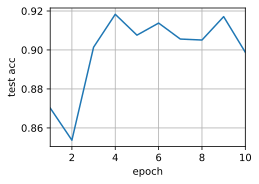

In [5]:
train(net, num_gpus=1, batch_size=256, lr=0.1)


次に [**トレーニングに 2 つの GPU を使用**] します。 :numref: `sec_multi_gpu`で評価された LeNet と比較すると、ResNet-18 のモデルはかなり複雑です。ここで並列化が利点を発揮します。計算にかかる時間は、パラメータの同期にかかる時間よりも大幅に長くなります。これにより、並列化のオーバーヘッドが少なくなるため、スケーラビリティが向上します。


test acc: 0.89, 8.8 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


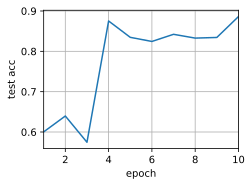

In [6]:
train(net, num_gpus=2, batch_size=512, lr=0.2)


## まとめ


- データは、データが見つかるデバイス上で自動的に評価されます。
- デバイス上のパラメータにアクセスする前に、各デバイス上のネットワークを必ず初期化してください。そうしないと、エラーが発生します。
- 最適化アルゴリズムは複数の GPU にわたって自動的に集約されます。

## 演習


1. このセクションでは ResNet-18 を使用します。さまざまなエポック、バッチ サイズ、学習率を試してください。計算にはより多くの GPU を使用します。これを 16 個の GPU (AWS p2.16xlarge インスタンスなど) で試してみるとどうなるでしょうか?
1. 場合によっては、デバイスが異なれば、提供されるコンピューティング能力も異なります。 GPU と CPU を同時に使用できます。仕事をどのように分担すればよいでしょうか？努力する価値はありますか?なぜ？なぜだめですか？



[ディスカッション](https://discuss.d2l.ai/t/1403)
